# Neural Machine Translation

We attempt to train a translation model that translates <b>French</b> text to <b>English</b>. We shall employ the [Transformer](https://arxiv.org/abs/1706.03762) architecture.

In [1]:
from fastai.text import *

In [2]:
path = Path('./data/giga-fren')

## Load and clean data

In [ ]:
#! wget https://s3.amazonaws.com/fast-ai-nlp/giga-fren.tgz -P {path}
#! tar xf {path}/giga-fren.tgz -C {path} 

We have a pretty <b>big</b> dataset here, instead of using all of it, we shall only seek out sentences in the dataset that are <b>questions</b>.

In [ ]:
#with open(path/'giga-fren.release2.fixed.fr') as f:
#    fr = f.read().split('\n')

In [ ]:
#with open(path/'giga-fren.release2.fixed.en') as f:
#    en = f.read().split('\n')

In [ ]:
#re_eq = re.compile('^(Wh[^?.!]+\?)')
#re_fq = re.compile('^([^?.!]+\?)')
#en_fname = path/'giga-fren.release2.fixed.en'
#fr_fname = path/'giga-fren.release2.fixed.fr'

In [ ]:
#lines = ((re_eq.search(eq), re_fq.search(fq)) 
#         for eq, fq in zip(open(en_fname, encoding='utf-8'), open(fr_fname, encoding='utf-8')))
#qs = [(e.group(), f.group()) for e,f in lines if e and f]

In [ ]:
#qs = [(q1,q2) for q1,q2 in qs]
#df = pd.DataFrame({'fr': [q[1] for q in qs], 'en': [q[0] for q in qs]}, columns = ['en', 'fr'])
#df.to_csv(path/'questions_easy.csv', index=False)

In [3]:
df = pd.read_csv(path/'questions_easy.csv')
df.head()

,en,fr
0,What is light ?,Qu’est-ce que la lumière?
1,Who are we?,Où sommes-nous?
2,Where did we come from?,D'où venons-nous?
3,What would we do without it?,Que ferions-nous sans elle ?
4,What is the absolute location (latitude and lo...,Quelle sont les coordonnées (latitude et longi...


In [4]:
#Collate function for the Pytorch dataloader
def seq2seq_collate(samples:BatchSamples, pad_idx=1, pad_first=True, backwards=False):
    samples = to_data(samples)
    max_len_x,max_len_y = max([len(s[0]) for s in samples]),max([len(s[1]) for s in samples])
    res_x = torch.zeros(len(samples), max_len_x).long() + pad_idx
    res_y = torch.zeros(len(samples), max_len_y).long() + pad_idx
    if backwards: pad_first = not pad_first
    for i,s in enumerate(samples):
        if pad_first: 
            res_x[i,-len(s[0]):],res_y[i,-len(s[1]):] = LongTensor(s[0]),LongTensor(s[1])
        else:         
            res_x[i,:len(s[0]):],res_y[i,:len(s[1]):] = LongTensor(s[0]),LongTensor(s[1])
    if backwards: res_x,res_y = res_x.flip(1),res_y.flip(1)
    return res_x, res_y

In [5]:
#Seq2seq isn't natively supported by the fastai library, we need to manually monkeypatch it to include our collate fn
class Seq2SeqDataBunch(TextDataBunch):
    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, path:PathOrStr='.', bs:int=32, val_bs:int=None, pad_idx=1,
               pad_first=False, device:torch.device=None, no_check:bool=False, backwards:bool=False, **dl_kwargs) -> DataBunch:
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        collate_fn = partial(seq2seq_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
        train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs//2)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
        dataloaders = [train_dl]
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **dl_kwargs))
        return cls(*dataloaders, path=path, device=device, collate_fn=collate_fn, no_check=no_check)

In [6]:
class Seq2SeqTextList(TextList):
    _bunch = Seq2SeqDataBunch
    _label_cls = TextList

In [7]:
src = Seq2SeqTextList.from_df(df, path = path, cols='fr').split_by_rand_pct().label_from_df(cols='en', label_cls=TextList)

In [8]:
np.percentile([len(o) for o in src.train.x.items] + [len(o) for o in src.valid.x.items], 90)

29.0

In [9]:
np.percentile([len(o) for o in src.train.y.items] + [len(o) for o in src.valid.y.items], 90)

26.0

To make things easier for us, we remove the sentences that are over 30 words long.

In [10]:
src = src.filter_by_func(lambda x,y: len(x) > 30 or len(y) > 30)

In [11]:
len(src.train) + len(src.valid)

47389

In [12]:
data = src.databunch()

In [13]:
data.save()

In [47]:
data = load_data(path)

In [15]:
data.show_batch()

text,target
"xxbos xxmaj quels sont , ou encore quels devraient être , le rôle et les responsabilités du xxmaj secrétariat du xxmaj conseil du xxmaj trésor relativement aux systèmes partagés ?","xxbos xxmaj what is , or should be , the role and responsibilities of the xxmaj treasury xxmaj board xxmaj secretariat with regard to shared systems ?"
"xxbos xxmaj qu'est - ce qui pourrait bien me motiver , à titre de capitaine , à vraiment vouloir un jour me retrouver à la place de cet officier ?","xxbos xxmaj what 's the incentive for me as a xxunk to think , xxunk , i really want to be in that man 's shoes one day ?"
xxbos xxmaj pourquoi le xxmaj panier de provisions nordique révisé ( xxup ppnr ) remplace - t - il le xxmaj panier de provisions nordique ( xxup ppn ) ?,xxbos xxmaj why is the xxmaj revised xxmaj northern xxmaj food xxmaj basket ( xxup rnfb ) replacing the xxmaj northern xxmaj food xxmaj basket ( xxup nfb ) ?
xxbos xxmaj quelles mesures peuvent - elles être prises afin de permettre davantage au xxmaj parlement d’évaluer objectivement les raisons sous - jacentes et les nominations dans ce domaine ?,xxbos xxmaj what can be done to allow the xxmaj parliament better opportunities to objectively assess the rationale and appointments in this field ?
"xxbos xxmaj pourquoi ne pas concéder ce rôle à des joueurs privés comme xxunk et xxmaj xxunk xxmaj king , et les laisser fixer les normes s'appliquant aux fournisseurs ?","xxbos xxmaj why not give the role to corporate players , such as xxunk 's and xxmaj xxunk xxmaj king , and let them set the standards for suppliers ?"


## Transformer Architecture
Image is from the paper mentioned above.

![Transformer model](images/Transformer.png)

### Shifting

We add a transform to the dataloader that shifts the targets right and adds a padding at the beginning as shown in the diagram above (bottom right).

In [13]:
def shift_tfm(b):
    x,y = b
    y = F.pad(y, (1, 0), value=1)
    return [x,y[:,:-1]], y[:,1:]

In [14]:
data.add_tfm(shift_tfm)

### Embeddings

The input and output word embeddings are normal word embeddings (and we can use pretrained vectors here if we want to). However, unlike typical recurrent models like LSTMs and RCNNs, the transformer model has no temporal knowledge, so it has no idea of the relative positions of the words. As the paper suggests, we need to implement a positional encoding which are sinusoidal waves of certain frequencies.

In [15]:
class PositionalEncoding(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.register_buffer('freq', 1 / (10000 ** (torch.arange(0., d, 2.)/d)))
    
    def forward(self, pos:Tensor):
        inp = torch.ger(pos, self.freq)
        enc = torch.cat([inp.sin(), inp.cos()], dim=-1)
        return enc

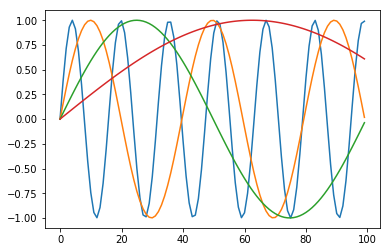

In [16]:
tst_encoding = PositionalEncoding(20)
res = tst_encoding(torch.arange(0,100).float())
_, ax = plt.subplots(1,1)
for i in range(1,5): ax.plot(res[:,i])

In [17]:
class TransformerEmbedding(nn.Module):
    def __init__(self, vocab_sz, emb_sz, inp_p=0.):
        super().__init__()
        self.emb_sz = emb_sz
        self.embed = embedding(vocab_sz, emb_sz)
        self.pos_enc = PositionalEncoding(emb_sz)
        self.drop = nn.Dropout(inp_p)
    
    def forward(self, inp): 
        pos = torch.arange(0, inp.size(1), device=inp.device).float()
        return self.drop(self.embed(inp) * math.sqrt(self.emb_sz) + self.pos_enc(pos))

### Feed Forward

The feed forward is just two linear layers with a residual connection and a LayerNorm at the end.

In [18]:
def feed_forward(d_model, d_ff, ff_p=0., double_drop=True):
    layers = [nn.Linear(d_model, d_ff), nn.ReLU()]
    if double_drop: layers.append(nn.Dropout(ff_p))
    return SequentialEx(*layers, nn.Linear(d_ff, d_model), nn.Dropout(ff_p), MergeLayer(), nn.LayerNorm(d_model))

### Multi-head attention

![Multi head attention](images/attention.png)

In [19]:
class MultiHeadAttention(nn.Module):    
    def __init__(self, n_heads, d_model, d_head=None, resid_p=0., attn_p=0., bias=True,
                 scale=True):
        super().__init__()
        d_head = ifnone(d_head, d_model//n_heads)
        self.n_heads,self.d_head,self.scale = n_heads,d_head,scale
        self.q_wgt = nn.Linear(d_model, n_heads * d_head, bias=bias)
        self.k_wgt = nn.Linear(d_model, n_heads * d_head, bias=bias)
        self.v_wgt = nn.Linear(d_model, n_heads * d_head, bias=bias)
        self.out = nn.Linear(n_heads * d_head, d_model, bias=bias)
        self.drop_att,self.drop_res = nn.Dropout(attn_p),nn.Dropout(resid_p)
        self.ln = nn.LayerNorm(d_model)
        
    def forward(self, q, k, v, mask=None):
        return self.ln(q + self.drop_res(self.out(self._apply_attention(q, k, v, mask=mask))))
    
    def _apply_attention(self, q, k, v, mask=None):
        bs,seq_len = q.size(0),q.size(1)
        wq,wk,wv = self.q_wgt(q),self.k_wgt(k),self.v_wgt(v)
        wq,wk,wv = map(lambda x:x.view(bs, x.size(1), self.n_heads, self.d_head), (wq,wk,wv))
        wq,wk,wv = wq.permute(0, 2, 1, 3),wk.permute(0, 2, 3, 1),wv.permute(0, 2, 1, 3)
        attn_score = torch.matmul(wq, wk)
        if self.scale: attn_score = attn_score.div_(self.d_head ** 0.5)
        if mask is not None: 
            attn_score = attn_score.float().masked_fill(mask, -float('inf')).type_as(attn_score)
        attn_prob = self.drop_att(F.softmax(attn_score, dim=-1))
        attn_vec = torch.matmul(attn_prob, wv)
        return attn_vec.permute(0, 2, 1, 3).contiguous().view(bs, seq_len, -1)

### Masking

The attention layer uses a mask to avoid paying attention to certain timesteps. The paper mentions that we should mask the padding tokens, but it seems that for now we shall skip this because it gives us issues when the input and output length aren't the same. The second thing is that since this model isn't recurrent, we need to mask (in the output) all the tokens that it isn't supposed to have seen yet, i.e. at each time-step the model only should have knowledge of the output words up until that time-step only.

In [20]:
def get_padding_mask(inp, pad_idx:int=1):
    return None


In [21]:
def get_output_mask(inp, pad_idx:int=1):
    return torch.triu(inp.new_ones(inp.size(1),inp.size(1)), diagonal=1)[None,None].byte()

The idea is that we want to set the activations of the time-steps that the model shouldn't have seen yet to negative infinity, hence when we take a softmax those activations will go to zero.
Example of mask for the future tokens:

In [22]:
torch.triu(torch.ones(10,10), diagonal=1).byte()

tensor([[0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.uint8)

### Encoder and Decoder blocks

We now put all the building blocks together and define the transformer architecture.
![Transformer model](images/Transformer.png)

In [23]:
class EncoderBlock(nn.Module):
    def __init__(self, n_heads, d_model, d_head, d_inner, resid_p=0., attn_p=0., ff_p=0.,
                 bias:bool=True, scale:bool=True, double_drop:bool=True):
        super().__init__()
        self.mha = MultiHeadAttention(n_heads, d_model, d_head, resid_p=resid_p, attn_p=attn_p, bias=bias, scale=scale)
        self.ff  = feed_forward(d_model, d_inner, ff_p=ff_p, double_drop=double_drop)
    
    def forward(self, x, mask=None): 
        return self.ff(self.mha(x, x, x, mask=mask))

In [24]:
class DecoderBlock(nn.Module):
    def __init__(self, n_heads, d_model, d_head, d_inner, resid_p=0., attn_p=0., ff_p=0.,
                 bias=True, scale=True, double_drop=True):
        super().__init__()
        self.mha1 = MultiHeadAttention(n_heads, d_model, d_head, resid_p=resid_p, attn_p=attn_p, bias=bias, scale=scale)
        self.mha2 = MultiHeadAttention(n_heads, d_model, d_head, resid_p=resid_p, attn_p=attn_p, bias=bias, scale=scale)
        self.ff   = feed_forward(d_model, d_inner, ff_p=ff_p, double_drop=double_drop)
    
    def forward(self, x, enc, mask_in=None, mask_out=None): 
        y = self.mha1(x, x, x, mask_out)
        return self.ff(self.mha2(y, enc, enc, mask=mask_in))

In [25]:
class Transformer(nn.Module):    
    def __init__(self, inp_vsz, out_vsz, n_layers=6, n_heads=8, d_model=256, d_head=32, 
                 d_inner=1024, inp_p=0.1, resid_p=0.1, attn_p=0.1, ff_p=0.1, bias=True, 
                 scale=True, double_drop=True, pad_idx=1):
        super().__init__()
        self.enc_emb = TransformerEmbedding(inp_vsz, d_model, inp_p)
        self.dec_emb = TransformerEmbedding(out_vsz, d_model, 0.)
        self.encoder = nn.ModuleList([EncoderBlock(n_heads, d_model, d_head, d_inner, resid_p, attn_p, 
                                                   ff_p, bias, scale, double_drop) for _ in range(n_layers)])
        self.decoder = nn.ModuleList([DecoderBlock(n_heads, d_model, d_head, d_inner, resid_p, attn_p, 
                                                   ff_p, bias, scale, double_drop) for _ in range(n_layers)])
        self.out = nn.Linear(d_model, out_vsz)
        self.out.weight = self.dec_emb.embed.weight
        self.pad_idx = pad_idx
        
    def forward(self, inp, out):
        mask_in  = get_padding_mask(inp, self.pad_idx)
        mask_out = get_output_mask (out, self.pad_idx)
        enc,out = self.enc_emb(inp),self.dec_emb(out)
        for enc_block in self.encoder: enc = enc_block(enc, mask_in)
        for dec_block in self.decoder: out = dec_block(out, enc, mask_in, mask_out)
        return self.out(out)

#### BLEU Metric 
The BLEU metric is used to evaluate the performance of translation models. It's based on the precision you hit with n-grams in your prediction compared to your target.

In [26]:
class NGram():
    def __init__(self, ngram, max_n=5000): self.ngram,self.max_n = ngram,max_n
    def __eq__(self, other):
        if len(self.ngram) != len(other.ngram): return False
        return np.all(np.array(self.ngram) == np.array(other.ngram))
    #so that we can use counter later
    def __hash__(self): return int(sum([o * self.max_n**i for i,o in enumerate(self.ngram)]))

In [27]:
def get_grams(x, n, max_n=5000):
    return x if n==1 else [NGram(x[i:i+n], max_n=max_n) for i in range(len(x)-n+1)]

In [28]:
def get_correct_ngrams(pred, targ, n, max_n=5000):
    pred_grams,targ_grams = get_grams(pred, n, max_n=max_n),get_grams(targ, n, max_n=max_n)
    pred_cnt,targ_cnt = Counter(pred_grams),Counter(targ_grams)
    return sum([min(c, targ_cnt[g]) for g,c in pred_cnt.items()]),len(pred_grams)

In [29]:
class CorpusBLEU(Callback):
    def __init__(self, vocab_sz):
        self.vocab_sz = vocab_sz
        self.name = 'bleu'
    
    def on_epoch_begin(self, **kwargs):
        self.pred_len,self.targ_len,self.corrects,self.counts = 0,0,[0]*4,[0]*4
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        last_output = last_output.argmax(dim=-1)
        for pred,targ in zip(last_output.cpu().numpy(),last_target.cpu().numpy()):
            self.pred_len += len(pred)
            self.targ_len += len(targ)
            for i in range(4):
                c,t = get_correct_ngrams(pred, targ, i+1, max_n=self.vocab_sz)
                self.corrects[i] += c
                self.counts[i]   += t
    
    def on_epoch_end(self, last_metrics, **kwargs):
        precs = [c/t for c,t in zip(self.corrects,self.counts)]
        len_penalty = exp(1 - self.targ_len/self.pred_len) if self.pred_len < self.targ_len else 1
        bleu = len_penalty * ((precs[0]*precs[1]*precs[2]*precs[3]) ** 0.25)
        return add_metrics(last_metrics, bleu)

### Training

In [30]:
model = Transformer(len(data.train_ds.x.vocab.itos), len(data.train_ds.y.vocab.itos), d_model=256)

In [31]:
learn = Learner(data, model, metrics=[accuracy, CorpusBLEU(len(data.train_ds.y.vocab.itos))], 
                loss_func = CrossEntropyFlat())

In [32]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


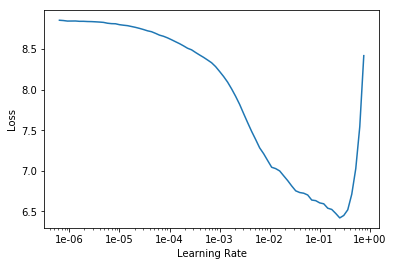

In [33]:
learn.recorder.plot(suggest=True)

From experimentation, using a smaller LR seems to make training more successful here.

In [142]:
learn.fit_one_cycle(8, 5e-4, div_factor=5)

epoch,train_loss,valid_loss,accuracy,bleu,time
0,2.343735,2.470800,0.618743,0.458274,01:27
1,1.861705,1.957763,0.687678,0.504623,01:27
2,1.570372,1.634811,0.726458,0.544154,01:27
3,1.339420,1.450445,0.750295,0.571839,01:26
4,1.141070,1.341792,0.765446,0.590702,01:27
5,0.946689,1.290690,0.773968,0.600434,01:26
6,0.830916,1.275420,0.778801,0.607939,01:27
7,0.775290,1.279038,0.779081,0.608253,01:27


In [143]:
learn.save('transformer-1')

In [144]:
def get_predictions(learn, ds_type=DatasetType.Valid):
    learn.model.eval()
    inputs, targets, outputs = [],[],[]
    with torch.no_grad():
        for xb,yb in progress_bar(learn.dl(ds_type)):
            out = learn.model(*xb)
            for x,y,z in zip(xb[0],xb[1],out):
                inputs.append(learn.data.train_ds.x.reconstruct(x))
                targets.append(learn.data.train_ds.y.reconstruct(y))
                outputs.append(learn.data.train_ds.y.reconstruct(z.argmax(1)))
    return inputs, targets, outputs

In [ ]:
learn.load('transformer-1')

In [175]:
inputs, targets, outputs = get_predictions(learn)

In [176]:
inputs[10],targets[10],outputs[10]

(Text xxbos xxmaj quel est donc le problème relatif à la protection de la vie privée dans le cas des résultats de recensement qui respectent la règle de xxunk ans ?,
 Text xxbos xxmaj what privacy concern could xxunk attach to census returns that meet the xxunk year rule ?,
 Text xxbos xxmaj what is issues to be the to the performance in will the census outcomes - -)

In [177]:
inputs[700],targets[700],outputs[700]

(Text xxbos xxmaj quelle flèche , a ou b , indique la direction d'un vent en surface qui s'est xxunk aux vents à xxunk mètres ?,
 Text xxbos xxmaj which arrow , a or b , indicates the direction of a surface wind which has xxunk to xxunk at the xxunk metre level ?,
 Text xxbos xxmaj which arrow(s , b or b , does the wind of a xxunk xxunk xxunk xxunk xxunk to xxunk xxunk the xxunk xxunk xxunk ?)

In [178]:
inputs[701],targets[701],outputs[701]

(Text xxbos à quel stade se trouve votre entreprise en ce qui concerne l'adoption de moyens de protéger les renseignements personnels contre l'accès non autorisé ?,
 Text xxbos xxmaj what stage is your company at putting in place safeguards to protect personal information from xxunk access ?,
 Text xxbos xxmaj what stage of your company taking the a terms to to protect non information against non ? to)

In [179]:
inputs[2500],targets[2500],outputs[2500]

(Text xxbos xxmaj quel type de combustible utilisent - elles ( eau , charbon , pétrole , xxunk ) ?,
 Text xxbos xxmaj what kind of fuel does each of them use ( water , coal , oil , uranium ) ?,
 Text xxbos xxmaj what type of fuel do fuel water xxunk use ( xxunk , xxunk , xxunk , xxunk ) ?)

In [180]:
inputs[4002],targets[4002],outputs[4002]

(Text xxbos à votre avis , dans quel but élabore - t - on des scénarios ?,
 Text xxbos xxmaj what , in your view , is the purpose of making the scenarios ?,
 Text xxbos xxmaj what do in your view , is the purpose of the that scenarios ?)

### Label Smoothing

In [151]:
model = Transformer(len(data.train_ds.x.vocab.itos), len(data.train_ds.y.vocab.itos), d_model=256)

In [152]:
learn = Learner(data, model, metrics=[accuracy, CorpusBLEU(len(data.train_ds.y.vocab.itos))], 
                loss_func=FlattenedLoss(LabelSmoothingCrossEntropy, axis=-1))

In [153]:
learn.fit_one_cycle(8, 5e-4, div_factor=5)

epoch,train_loss,valid_loss,accuracy,bleu,time
0,3.258835,3.356584,0.621396,0.457460,01:26
1,2.872118,2.932373,0.688245,0.505038,01:28
2,2.609491,2.666561,0.725763,0.542954,01:28
3,2.369570,2.509987,0.747867,0.566677,01:29
4,2.250779,2.411248,0.765274,0.588937,01:27
5,2.097184,2.366729,0.775548,0.602242,01:27
6,1.998518,2.357349,0.778781,0.607040,01:27
7,1.933331,2.358587,0.779548,0.608569,01:28


In [154]:
learn.save('transformer-2')

In [155]:
learn.fit_one_cycle(8, 5e-4, div_factor=5)

epoch,train_loss,valid_loss,accuracy,bleu,time
0,1.997606,2.367188,0.778038,0.606565,01:26
1,2.059385,2.377284,0.773458,0.601094,01:28
2,2.025744,2.355872,0.778526,0.608214,01:26
3,1.919910,2.340731,0.783554,0.615082,01:27
4,1.821205,2.330087,0.788712,0.623469,01:28
5,1.720710,2.327667,0.792648,0.630422,01:28
6,1.630548,2.343340,0.794246,0.633728,01:28
7,1.587363,2.347243,0.794411,0.633843,01:28


In [156]:
learn.save('transformer-3')

In [ ]:
learn.load('transformer-3')

In [182]:
inputs, targets, outputs = get_predictions(learn)

In [183]:
inputs[10],targets[10],outputs[10]

(Text xxbos xxmaj quel est donc le problème relatif à la protection de la vie privée dans le cas des résultats de recensement qui respectent la règle de xxunk ans ?,
 Text xxbos xxmaj what privacy concern could xxunk attach to census returns that meet the xxunk year rule ?,
 Text xxbos xxmaj what is problem about be in to the results with kind the census of - of)

In [184]:
inputs[700],targets[700],outputs[700]

(Text xxbos xxmaj quelle flèche , a ou b , indique la direction d'un vent en surface qui s'est xxunk aux vents à xxunk mètres ?,
 Text xxbos xxmaj which arrow , a or b , indicates the direction of a surface wind which has xxunk to xxunk at the xxunk metre level ?,
 Text xxbos xxmaj which solution , a or b , indicates the wind that surface wind xxunk xxunk influenced been to an ? the procedure ? ? ?)

In [185]:
inputs[701],targets[701],outputs[701]

(Text xxbos à quel stade se trouve votre entreprise en ce qui concerne l'adoption de moyens de protéger les renseignements personnels contre l'accès non autorisé ?,
 Text xxbos xxmaj what stage is your company at putting in place safeguards to protect personal information from xxunk access ?,
 Text xxbos xxmaj which stage is your company in the into terms regarding to protect the information against non access ?)

In [186]:
inputs[2500],targets[2500],outputs[2500]

(Text xxbos xxmaj quel type de combustible utilisent - elles ( eau , charbon , pétrole , xxunk ) ?,
 Text xxbos xxmaj what kind of fuel does each of them use ( water , coal , oil , uranium ) ?,
 Text xxbos xxmaj what type of fuel do fuel ( the ( ( on , oil , oil , oil ) ?)

In [187]:
inputs[4002],targets[4002],outputs[4002]

(Text xxbos à votre avis , dans quel but élabore - t - on des scénarios ?,
 Text xxbos xxmaj what , in your view , is the purpose of making the scenarios ?,
 Text xxbos xxmaj what is in your opinion , is the purpose of the that scenarios ?)